   *«Я была готова уйти отсюда, прежде чем пришла.»*

   -- Дарья

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Вес" data-toc-modified-id="Вес-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вес</a></span></li><li><span><a href="#Увеличение-выборки" data-toc-modified-id="Увеличение-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Увеличение выборки</a></span></li><li><span><a href="#Уменьшение-выборки" data-toc-modified-id="Уменьшение-выборки-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Уменьшение выборки</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. 

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Извлечём данные и посмотрим на них.

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


К несчастью, для указаных данных нет чёткого описания, в частности, для столбца `Exited` не известно какая цифра соответсвует ушедшим клиентам, а какая оставшимся. Для определённости будем считать 0 - ушедшими клиентами, а 1 - оставшимися.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Приведём названия столбцов к более удобному виду.

In [4]:
data = data.rename(columns={'RowNumber' : 'row_number',
                            'CustomerId' : 'customer_id',
                            'Surname' : 'surname',
                            'CreditScore' : 'credit_score',
                            'Geography' : 'geography',
                            'Gender' : 'gender',
                            'Age' : 'age',
                            'Tenure' : 'tenure',
                            'Balance' : 'balance',
                            'NumOfProducts' : 'num_of_products',
                            'HasCrCard' : 'has_cr_card',
                            'IsActiveMember' : 'is_active_member',
                            'EstimatedSalary' : 'estimated_salary',
                            'Exited' : 'exited'})

---

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В ходе выполнения задачи нам будет необходимо построить модель прогноза факта ухода клиента, очевидно, что на этот факт слабо влияет фамилия клиента. Удалим информацию о ней из нашего анализа.

In [6]:
data = data.drop('surname', axis=1)

Тоже самое можно сказать про индекс строки в данных

In [7]:
data = data.drop('row_number', axis=1)

и про уникальные идентификаторы клиентов.

In [8]:
data = data.drop('customer_id', axis=1)

Также можно отметить, что в данных представлена информация о клиентах из трёх стран.

In [9]:
data['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

Преобразуем информацию о странах и поле клиентов в таблице из категориальной в численную техникой прямого кодирования.

In [10]:
data = pd.get_dummies(data, columns=['geography', 'gender'], drop_first=True)

В данных отсутсвует информация о времени явления некоторых людей клиентом банка. Поскольку нет информации о том, чем можно было бы эти пропуски заменить и строк с этими пропусками намного меньше, чем строк без пропусков, то удалим их, чтобы они не оказывали влияние на дальнейший анализ.

In [11]:
data = data[~data['tenure'].isna()].reset_index(drop=True)

В ходе анализа данных других аномалий в представленных данных не выявлено.

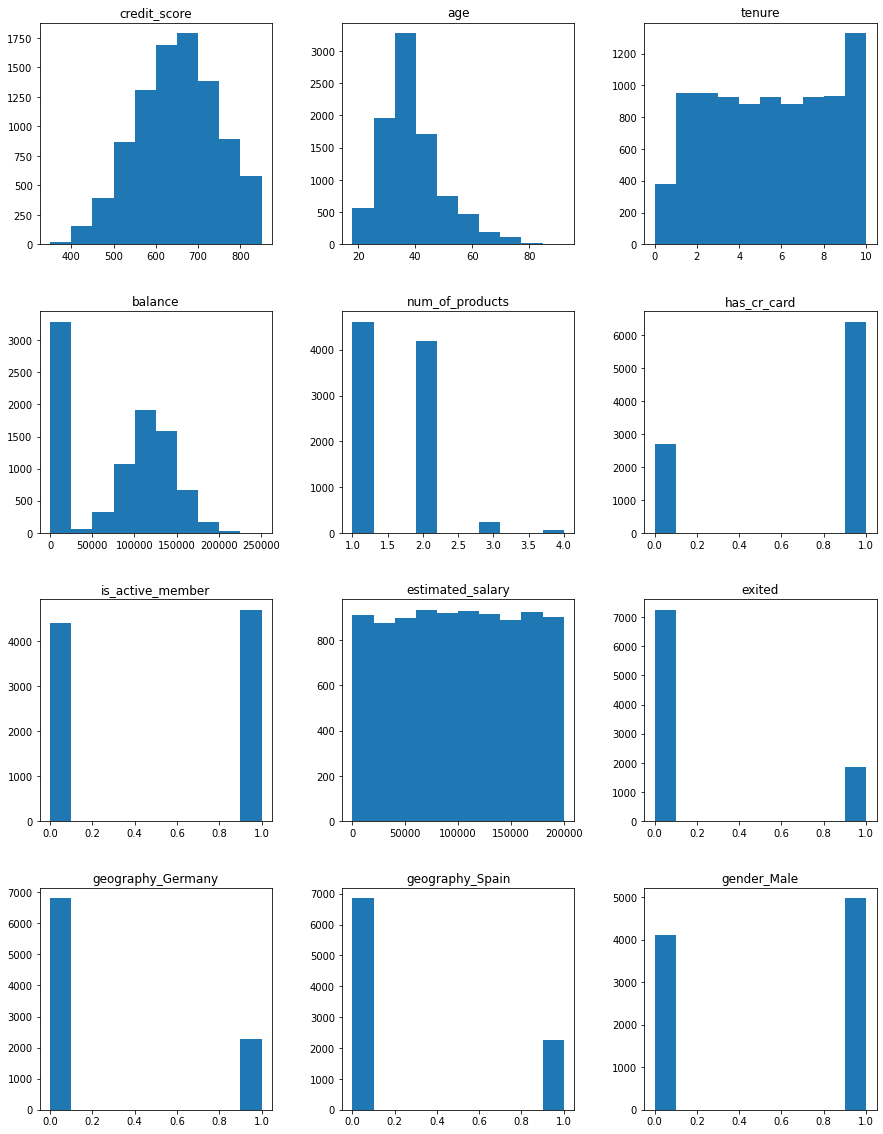

In [12]:
data.hist(figsize=(15, 20), grid=False);

В итоге данные преобразованы к виду:

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       9091 non-null   int64  
 1   age                9091 non-null   int64  
 2   tenure             9091 non-null   float64
 3   balance            9091 non-null   float64
 4   num_of_products    9091 non-null   int64  
 5   has_cr_card        9091 non-null   int64  
 6   is_active_member   9091 non-null   int64  
 7   estimated_salary   9091 non-null   float64
 8   exited             9091 non-null   int64  
 9   geography_Germany  9091 non-null   uint8  
 10  geography_Spain    9091 non-null   uint8  
 11  gender_Male        9091 non-null   uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 666.0 KB


Кореляция приведённых данных между друг другом достаточно слабая, что даёт основание обучить модель на всех оставшися данных.

In [14]:
data.corr()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
credit_score,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182,-0.023950,0.000428,0.001725,-0.008547
age,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037,0.283017,0.049038,-0.005622,-0.025631
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761,-0.003299,0.000810,0.012634
balance,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351,0.117218,0.401701,-0.136986,0.018030
num_of_products,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990,-0.050271,-0.009476,0.011903,-0.025176
has_cr_card,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136,-0.005411,0.009149,-0.017779,0.006016
is_active_member,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049,-0.155062,-0.016821,0.014800,0.025019
estimated_salary,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000,0.016029,0.011551,-0.010998,-0.002658
exited,-0.023950,0.283017,-0.016761,0.117218,-0.050271,-0.005411,-0.155062,0.016029,1.000000,0.178131,-0.055971,-0.110450
geography_Germany,0.000428,0.049038,-0.003299,0.401701,-0.009476,0.009149,-0.016821,0.011551,0.178131,1.000000,-0.332879,-0.023701


---

Кроме того, можно заметить, что данных об ушедших клиентах в разы больше данных о текущих клиентах. Это побуждает нас подумать о нейтрализации данного дисбаланса в соответсвующем разделе.

In [15]:
data['exited'].value_counts()

0    7237
1    1854
Name: exited, dtype: int64

## Исследование задачи

Для начала попробуем решить задачу без учёта дисбаланса. Целевым признаком в нашем исследовании является факт ухода клиента. Отделим целевые признаки от нецелевых.

In [16]:
f = data.drop(['exited'], axis=1)
t = data['exited']

Разделим исходные данные на обучающую, валидационную и тестовую выборки в соотношение 3:1:1 (60%:20%:20%).

In [17]:
rrrr = 42 # random_state

# разбиение признаков
f_trn, f_vld, f_tst = \
              np.split(f.sample(frac=1, random_state=rrrr), 
                       [int(.6*len(f)), int(.8*len(f))])

# разбиение целевого признака
t_trn, t_vld, t_tst = \
              np.split(t.sample(frac=1, random_state=rrrr), 
                       [int(.6*len(t)), int(.8*len(t))])

---

Поскольку целевые признаки имеют категориальную природу, то мы будем решать задачу классификации, а не регрессии. Т.е. мы постараемся определить по нецелевым признакам факт ухода клиента. В данном анализе мы задействуем модель случайного леса. Её отличительными особенностями являются высокая получаемая точность, но более низкая скорость обучения. Найдём лучшую c точки зрения среднего гармонического полноты и точности модель с заданным количеством деревьев. Код ниже возвращает F1 и площадь под кривой ошибок для такой модели.

0.5855263157894737 0.846836496517946


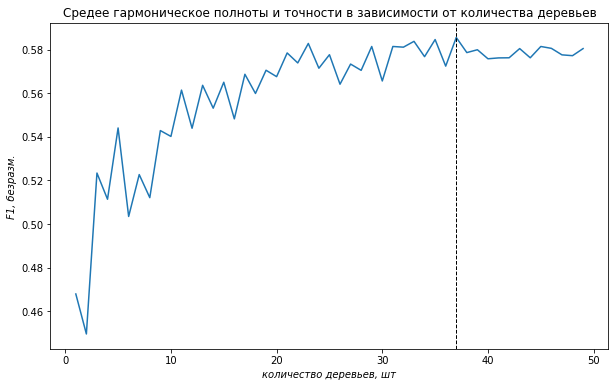

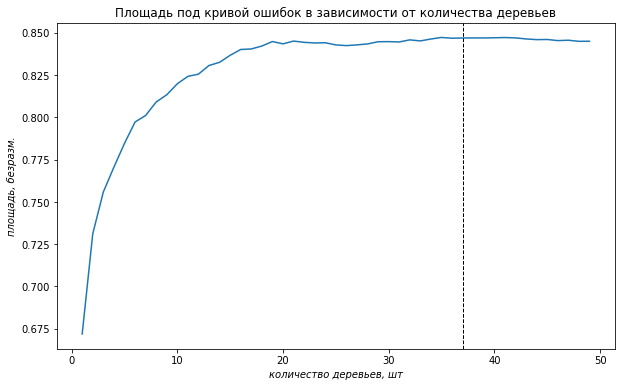

In [18]:
b_rfc_m = None             # лучшая модель
m_f1 = []; b_rfc_f1 = 0    # F1 лучшей модели
m_auc = []; b_auc = 0      # ACU лучшей по F1 модели
ii = 0
for i in range(1, 50):
    m = RandomForestClassifier(
        random_state=rrrr,
        n_estimators=i)                      # обучаем модель с заданным количеством деревьев
    m.fit(f_trn,t_trn)                       # тренируем модель по тренировочной выборке
    p_vld = m.predict(f_vld)                 # предсказание результатов
    pp_vld = m.predict_proba(f_vld)          # предсказание вероятностей результатов
    f1 = f1_score(t_vld,p_vld)               # F1 по валидационной выборке
    auc = roc_auc_score(t_vld, pp_vld[:, 1]) # AUC по валидационной выборке
    m_f1.append(f1)
    m_auc.append(auc)
    if f1 > b_rfc_f1:
        b_rfc_m = m
        b_rfc_f1 = f1
        b_auc = auc
        ii = i

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(range(1, 50),m_f1)
ax.axvline(x=ii, color='#000000', ls='--', linewidth=1)
plt.title('Средее гармоническое полноты и точности в зависимости от количества деревьев')
plt.ylabel('F1, безразм.', style='italic')
plt.xlabel('количество деревьев, шт', style='italic')

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(range(1, 50),m_auc)
ax.axvline(x=ii, color='#000000', ls='--', linewidth=1)
plt.title('Площадь под кривой ошибок в зависимости от количества деревьев')
plt.ylabel('площадь, безразм.', style='italic')
plt.xlabel('количество деревьев, шт', style='italic')

print(b_rfc_f1,b_auc)

F1 модели, тренированной на текущих данных, слишком мал. Для того чтобы повысить данный показатель необходимо обучить модель на данных с учтённым дисбалансом.

## Борьба с дисбалансом

Обучим несколько моделей на по-разному модифицированных данных, чтобы получить модель, которая бы обладала наиболее полной способностью к предсказаниям.

### Вес

Придадим объектам редкого класса больший вес, чтобы сбалансировать таким образом нашу модель.

0.5870646766169154 0.8284916201117318


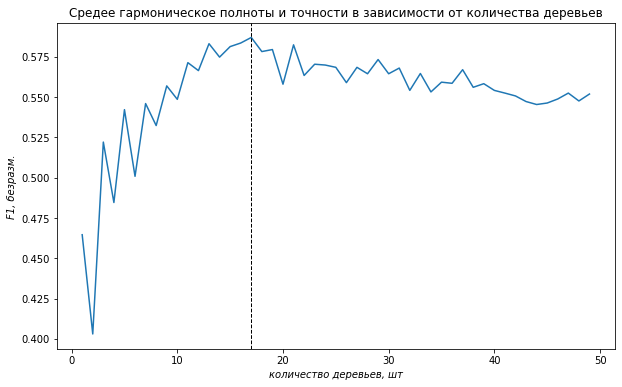

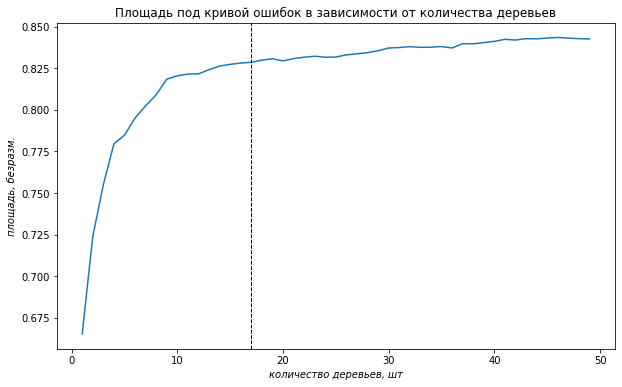

In [19]:
b_rfc_m_b = None             # лучшая модель
m_f1 = []; b_rfc_f1 = 0      # F1 лучшей модели
m_auc = []; b_auc = 0        # ACU лучшей по F1 модели
ii = 0
for i in range(1, 50):
    m = RandomForestClassifier(
        random_state=rrrr,
        n_estimators=i,                      # обучаем модель с заданным количеством деревьев
        class_weight='balanced')             # обучаем модель с взвешаннами классами
    m.fit(f_trn,t_trn)                       # тренируем модель по тренировочной выборке
    p_vld = m.predict(f_vld)                 # предсказание результатов
    pp_vld = m.predict_proba(f_vld)          # предсказание вероятностей результатов
    f1 = f1_score(t_vld,p_vld)               # F1 по валидационной выборке
    auc = roc_auc_score(t_vld, pp_vld[:, 1]) # AUC по валидационной выборке
    m_f1.append(f1)
    m_auc.append(auc)
    if f1 > b_rfc_f1:
        b_rfc_m_b = m
        b_rfc_f1 = f1
        b_auc = auc
        ii = i

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(range(1, 50),m_f1)
ax.axvline(x=ii, color='#000000', ls='--', linewidth=1)
plt.title('Средее гармоническое полноты и точности в зависимости от количества деревьев')
plt.ylabel('F1, безразм.', style='italic')
plt.xlabel('количество деревьев, шт', style='italic')

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(range(1, 50),m_auc)
ax.axvline(x=ii, color='#000000', ls='--', linewidth=1)
plt.title('Площадь под кривой ошибок в зависимости от количества деревьев')
plt.ylabel('площадь, безразм.', style='italic')
plt.xlabel('количество деревьев, шт', style='italic')

print(b_rfc_f1,b_auc)

Балансировка только незначительно улучшила нашу модель. В дальнейшем анализе мы будем прибегать к другим способам модификации данных.

### Увеличение выборки

Повторим несколько раз редко встречающиеся классы для того, чтобы модели было легче обучатся.

3 45 : 0.6000000000000001 0.845691436442948
4 23 : 0.6197991391678622 0.8458444937629142
5 23 : 0.6197991391678622 0.8458444937629142
> 4 23 : 0.6197991391678622 0.8458444937629142


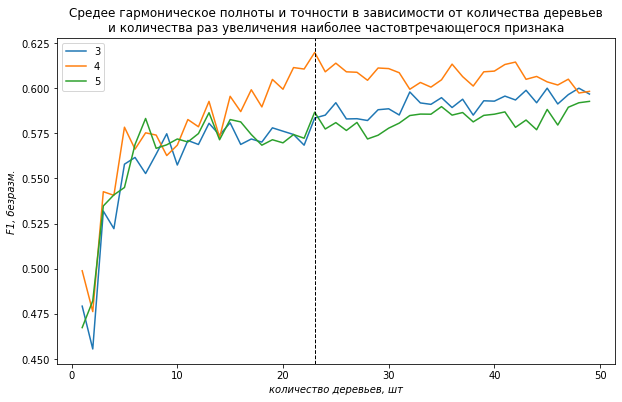

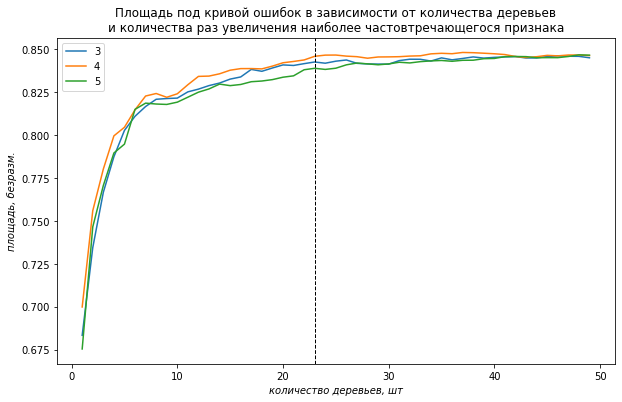

In [20]:
# увеличивает выборку, повторяя строки наимение встречающегося признака указанное количество раз
# признаки, целевые признаки, количество повторенй, random_state
def upsample(f, t, n, r):
    underdog = t_vld.value_counts().index[-1]
    
    f_unddg = f[t == underdog]
    f_anthr = f[t != underdog]
    t_unddg = t[t == underdog]
    t_anthr = t[t != underdog]

    ff = pd.concat([f_anthr] + [f_unddg] * n)
    tt = pd.concat([t_anthr] + [t_unddg] * n)
    
    return shuffle(ff, tt, random_state=r)


m_f1 = []; m_auc = []
b_rfc_m_up = None # лучшая модель
b_rfc_f1 = 0      # F1 лучшей модели
b_auc = 0         # ACU лучшей по F1 модели
jj = ii = 0
for j in range(3, 6): # перебор по количеству увеличения наимениее встречающегося признака
    f_trn_up, t_trn_up = upsample(f_trn, t_trn, j, rrrr) 
    m_f1.append([]);
    m_auc.append([]);
    for i in range(1, 50):
        m = RandomForestClassifier(
            random_state=rrrr,
            n_estimators=i)                      # обучаем модель с заданным количеством деревьев
        m.fit(f_trn_up,t_trn_up)                 # тренируем модель по модифицированной тренировочной выборке
        p_vld = m.predict(f_vld)                 # предсказание результатов
        pp_vld = m.predict_proba(f_vld)          # предсказание вероятностей результатов
        f1 = f1_score(t_vld,p_vld)               # F1 по валидационной выборке
        auc = roc_auc_score(t_vld, pp_vld[:, 1]) # AUC по валидационной выборке
        m_f1[-1].append(f1)
        m_auc[-1].append(auc)
        if f1 > b_rfc_f1:
            b_rfc_m_up = m
            b_rfc_f1 = f1
            b_auc = auc
            ii = i
            jj = j
    print(j,ii,':',b_rfc_f1,b_auc)

fig, ax = plt.subplots(figsize=(10,6))
for j in range(0, 3):
    plt.plot(range(1, 50),m_f1[j])
ax.axvline(x=ii, color='#000000', ls='--', linewidth=1)
plt.title('Средее гармоническое полноты и точности в зависимости от количества деревьев\nи количества раз увеличения наиболее частовтречающегося признака')
plt.ylabel('F1, безразм.', style='italic')
plt.xlabel('количество деревьев, шт', style='italic')
plt.legend(range(3, 6))

fig, ax = plt.subplots(figsize=(10,6))
for j in range(0, 3):
    plt.plot(range(1, 50),m_auc[j])
ax.axvline(x=ii, color='#000000', ls='--', linewidth=1)
plt.title('Площадь под кривой ошибок в зависимости от количества деревьев\nи количества раз увеличения наиболее частовтречающегося признака')
plt.ylabel('площадь, безразм.', style='italic')
plt.xlabel('количество деревьев, шт', style='italic')
plt.legend(range(3, 6))

print('>',jj,ii,':',b_rfc_f1,b_auc)

Повторение редко встречающихся классов дало свои результаты. Показатель F1 модели вырос.

In [21]:
f_trn_up, t_trn_up = upsample(f_trn, t_trn, 4, rrrr)
t_trn_up.value_counts()

1    4520
0    4324
Name: exited, dtype: int64

---

In [22]:
t_trn.value_counts()

0    4324
1    1130
Name: exited, dtype: int64

Чтобы найти оптимальное число для устранения дисбаланса найдём отношение в котором находятся классы в текущем состоянии.

In [23]:
round(t_trn.value_counts()[0] / t_trn.value_counts()[1])

4

Используем это соотношение для построение оптимальной модели.

0.6197991391678622 0.8458444937629142


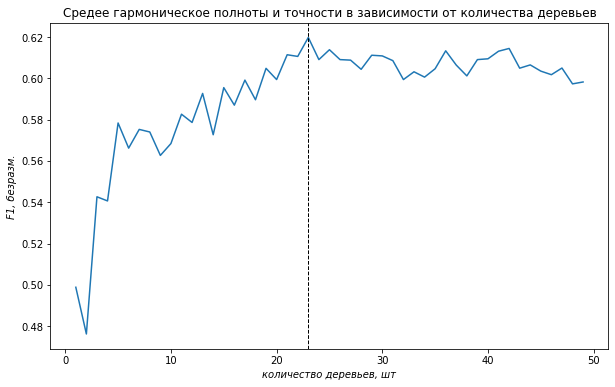

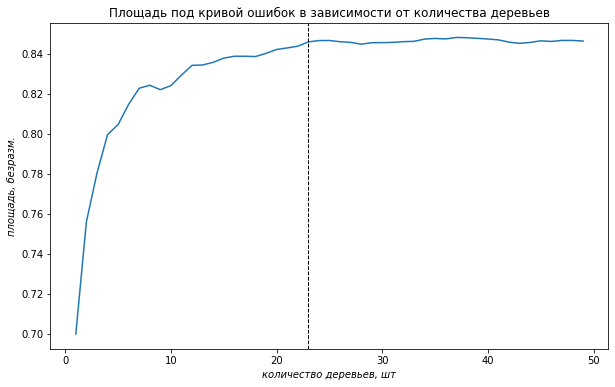

In [24]:
f_trn_up, t_trn_up = upsample(f_trn, t_trn,
                              round(t_trn.value_counts()[0] / t_trn.value_counts()[1]),
                              rrrr) 
b_rfc_m_up_2 = None          # лучшая модель
m_f1 = []; b_rfc_f1 = 0      # F1 лучшей модели
m_auc = []; b_auc = 0        # ACU лучшей по F1 модели
ii = 0
for i in range(1, 50):
    m = RandomForestClassifier(
        random_state=rrrr,
        n_estimators=i)                      # обучаем модель с заданным количеством деревьев
    m.fit(f_trn_up,t_trn_up)                 # тренируем модель по тренировочной выборке
    p_vld = m.predict(f_vld)                 # предсказание результатов
    pp_vld = m.predict_proba(f_vld)          # предсказание вероятностей результатов
    f1 = f1_score(t_vld,p_vld)               # F1 по валидационной выборке
    auc = roc_auc_score(t_vld, pp_vld[:, 1]) # AUC по валидационной выборке
    m_f1.append(f1)
    m_auc.append(auc)
    if f1 > b_rfc_f1:
        b_rfc_m_up_2 = m
        b_rfc_f1 = f1
        b_auc = auc
        ii = i

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(range(1, 50),m_f1)
ax.axvline(x=ii, color='#000000', ls='--', linewidth=1)
plt.title('Средее гармоническое полноты и точности в зависимости от количества деревьев')
plt.ylabel('F1, безразм.', style='italic')
plt.xlabel('количество деревьев, шт', style='italic')

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(range(1, 50),m_auc)
ax.axvline(x=ii, color='#000000', ls='--', linewidth=1)
plt.title('Площадь под кривой ошибок в зависимости от количества деревьев')
plt.ylabel('площадь, безразм.', style='italic')
plt.xlabel('количество деревьев, шт', style='italic')

print(b_rfc_f1,b_auc)

### Уменьшение выборки

Уберём часть часто повторяющихся классов, чтобы придать больший вес оставшимся.

0.3 28 : 0.5736434108527132 0.8422237315374607
0.5 23 : 0.5913705583756346 0.8464758552077754
0.7 32 : 0.6039453717754174 0.8492835004209075
0.9 32 : 0.6039453717754174 0.8492835004209075
> 0.7 32 : 0.6039453717754174 0.8492835004209075


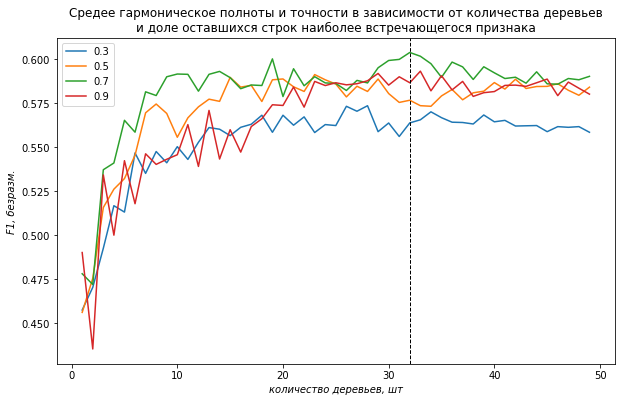

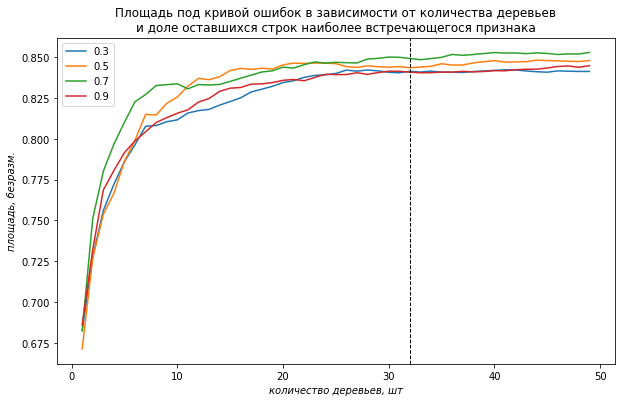

In [25]:
# уменьшая выборку, убирая случайные строки наиболее встречающегося признака
# признаки, целевые признаки, доля остающихся строк, random_state
def downsample(f, t, n, r):
    overdog = t_vld.value_counts().index[0]
    
    f_ovrdg = f[t == overdog]
    f_anthr = f[t != overdog]
    t_ovrdg = t[t == overdog]
    t_anthr = t[t != overdog]
    
    ff = pd.concat([f_ovrdg.sample(frac=n, random_state=r)] + [f_anthr])
    tt = pd.concat([t_ovrdg.sample(frac=n, random_state=r)] + [t_anthr])
    
    return shuffle(ff, tt, random_state=r)


m_f1 = []; m_auc = []
b_rfc_m_dwn = None # лучшая модель
b_rfc_f1 = 0       # F1 лучшей модели
b_auc = 0          # ACU лучшей по F1 модели
jj = ii = 0
for j in np.arange(0.3, 0.9, 0.2): # перебор по доле оставшихся строк наиболее встречающегося признака
    j = round(j * 10) / 10
    f_trn_dwn, t_trn_dwn = downsample(f_trn, t_trn, j, rrrr) 
    m_f1.append([]);
    m_auc.append([]);
    for i in range(1, 50):
        m = RandomForestClassifier(
            random_state=rrrr,
            n_estimators=i)                      # обучаем модель с заданным количеством деревьев
        m.fit(f_trn_dwn,t_trn_dwn)               # тренируем модель по модифицированной тренировочной выборке
        p_vld = m.predict(f_vld)                 # предсказание результатов
        pp_vld = m.predict_proba(f_vld)          # предсказание вероятностей результатов
        f1 = f1_score(t_vld,p_vld)               # F1 по валидационной выборке
        auc = roc_auc_score(t_vld, pp_vld[:, 1]) # AUC по валидационной выборке
        m_f1[-1].append(f1)
        m_auc[-1].append(auc)
        if f1 > b_rfc_f1:
            b_rfc_m_dwn = m
            b_rfc_f1 = f1
            b_auc = auc
            ii = i
            jj = j
    print(j,ii,':',b_rfc_f1,b_auc)

fig, ax = plt.subplots(figsize=(10,6))
for j in range(0, 4):
    plt.plot(range(1, 50),m_f1[j])
ax.axvline(x=ii, color='#000000', ls='--', linewidth=1)
plt.title('Средее гармоническое полноты и точности в зависимости от количества деревьев\nи доле оставшихся строк наиболее встречающегося признака')
plt.ylabel('F1, безразм.', style='italic')
plt.xlabel('количество деревьев, шт', style='italic')
plt.legend(['%.1f' % a for a in np.arange(0.3, 0.9, 0.2).tolist()])

fig, ax = plt.subplots(figsize=(10,6))
for j in range(0, 4):
    plt.plot(range(1, 50),m_auc[j])
ax.axvline(x=ii, color='#000000', ls='--', linewidth=1)
plt.title('Площадь под кривой ошибок в зависимости от количества деревьев\nи доле оставшихся строк наиболее встречающегося признака')
plt.ylabel('площадь, безразм.', style='italic')
plt.xlabel('количество деревьев, шт', style='italic')
plt.legend(['%.1f' % a for a in np.arange(0.3, 0.9, 0.2).tolist()])

print('>',jj,ii,':',b_rfc_f1,b_auc)

Данных подход также можно назвать успешным, как и увеличение выборки, поскольку показатель F1 модели возрос.

In [26]:
f_trn_dwn, t_trn_dwn = downsample(f_trn, t_trn, 0.7, rrrr) 
t_trn_dwn.value_counts()

0    3027
1    1130
Name: exited, dtype: int64

---

In [27]:
t_trn.value_counts()

0    4324
1    1130
Name: exited, dtype: int64

Чтобы найти оптимальное число для устранения дисбаланса найдём отношение в котором находятся классы в текущем состоянии.

In [28]:
t_trn.value_counts()[1] / t_trn.value_counts()[0]

0.26133209990749307

Используем это соотношение для построение оптимальной модели.

0.5612565445026179 0.8395289660978037


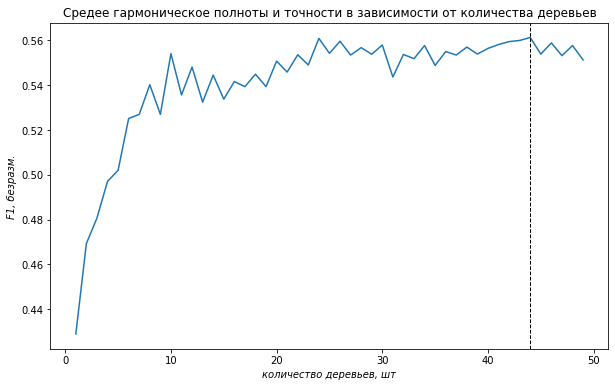

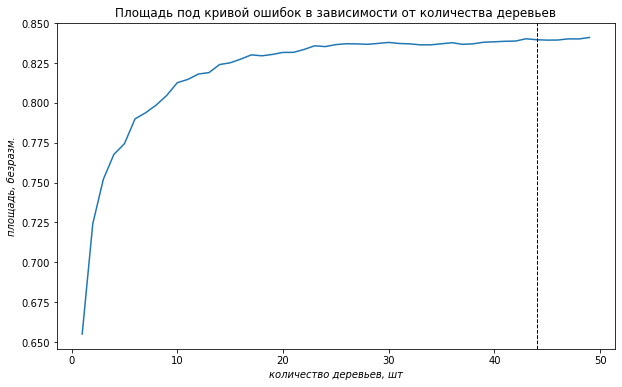

In [29]:
f_trn_dwn, t_trn_dwn = downsample(f_trn, t_trn, t_trn.value_counts()[1] / t_trn.value_counts()[0], rrrr) 
b_rfc_m_dwn_2 = None         # лучшая модель
m_f1 = []; b_rfc_f1 = 0      # F1 лучшей модели
m_auc = []; b_auc = 0        # ACU лучшей по F1 модели
ii = 0
for i in range(1, 50):
    m = RandomForestClassifier(
        random_state=rrrr,
        n_estimators=i)                      # обучаем модель с заданным количеством деревьев
    m.fit(f_trn_dwn,t_trn_dwn)               # тренируем модель по тренировочной выборке
    p_vld = m.predict(f_vld)                 # предсказание результатов
    pp_vld = m.predict_proba(f_vld)          # предсказание вероятностей результатов
    f1 = f1_score(t_vld,p_vld)               # F1 по валидационной выборке
    auc = roc_auc_score(t_vld, pp_vld[:, 1]) # AUC по валидационной выборке
    m_f1.append(f1)
    m_auc.append(auc)
    if f1 > b_rfc_f1:
        b_rfc_m_dwn_2 = m
        b_rfc_f1 = f1
        b_auc = auc
        ii = i

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(range(1, 50),m_f1)
ax.axvline(x=ii, color='#000000', ls='--', linewidth=1)
plt.title('Средее гармоническое полноты и точности в зависимости от количества деревьев')
plt.ylabel('F1, безразм.', style='italic')
plt.xlabel('количество деревьев, шт', style='italic')

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(range(1, 50),m_auc)
ax.axvline(x=ii, color='#000000', ls='--', linewidth=1)
plt.title('Площадь под кривой ошибок в зависимости от количества деревьев')
plt.ylabel('площадь, безразм.', style='italic')
plt.xlabel('количество деревьев, шт', style='italic')

print(b_rfc_f1,b_auc)

---

Придавать обектам класса разный вес в данном анализе оказалось не лучшим решением в отличие от увеличиния или уменьшения выборки, модели обученные на данных которых показали наилучшие результаты с точки зрения среднего гармонического полноты и точности.

## Тестирование модели

Наилучшие показатели проявила модель с увеличенной выборкой. Возьмём её, её данные и посмотрим как она покажет себя на тестовых данных.

In [30]:
m = b_rfc_m_up            # берём наиболее удачную модель
f_trn_up, t_trn_up = upsample(f_trn, t_trn, 4, rrrr)
m.fit(f_trn_up, t_trn_up) # тренируем модель по тренировочной выборке

p_vld = m.predict(f_vld)        # предсказание результатов по валитационной выборке
pp_vld = m.predict_proba(f_vld) # предсказание вероятностей результатов по валидационной выборке

p_tst = m.predict(f_tst)        # предсказание результатов по тестовой выборке
pp_tst = m.predict_proba(f_tst) # предсказание вероятностей результатов по тестовой выборке


print('Валидационная выборка:\nF1:', f1_score(t_vld,p_vld),
      '\nAUC:', roc_auc_score(t_vld, pp_vld[:, 1]),
      '\nТочность:',  accuracy_score(t_vld,p_vld))
print('Тестовая выборка:\nF1:', f1_score(t_tst,p_tst),
      '\nAUC:', roc_auc_score(t_tst, pp_tst[:, 1]),
      '\nТочность:',  accuracy_score(t_tst,p_tst))

Валидационная выборка:
F1: 0.6197991391678622 
AUC: 0.8458444937629142 
Точность: 0.8542354235423543
Тестовая выборка:
F1: 0.5902097902097901 
AUC: 0.830809818765772 
Точность: 0.8389224848818032


Среднее гармоническое полноты и точности тестовой выборки упало по сравнению с валидационной, но всё ещё является довольно высоким.

## Вывод

В ходе данного исследования была получена модель, способная предсказать факт ухода клиетна банка по указанным данным о нём. Данная модель была получена путём уменьшения информации об ушедших клиентах в обучаемой модели по сравнению с оригинальными данными в половину от всех данных об ушедших клиентах в оригинальных данных. Среднее гармоническое точности и полноны такой модели составило ~0.59 что является достаточном показателем для данной модели.